In [1]:
import pandas as pd
import pandas.io.sql as pd_sql
from pandas import Series, DataFrame, Panel
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from pylab import *
import datetime as date
import scipy.optimize
import scipy.stats
import seaborn as sns

In [24]:
## read excel file #########################################################################
DB_Dump = pd.ExcelFile('20171213_NEPADS_dmp.xlsx')
db_parse = DB_Dump.parse(sheetname='20171213_NEPADS_dmp')
d_df = db_parse[['Main ID','Project Name','Type','Due Date','Date Received','Lead Reviewer','Lead Agencies','Locations','Resolution Status','Public Rating']]

# Select the rows between two dates
d_df.loc[:,'Due Date'] = pd.to_datetime(d_df.loc[:,'Due Date'])
in_range_df = d_df.loc[d_df['Date Received'].isin(pd.date_range("2014-09-01", "2017-08-31"))]

###########################################################################################
rating_dict = {"ec2": "EC2", "Ec2": "EC2", "LO1":"LO","ER2":"EC2","NR - No rating":"NR"}
d_df['Public Rating'].replace(rating_dict, inplace=True)
### Data Parsing for DateRange Pie chart ##################################################

### Data Parsing for Global Stats/Plots ####################################################
nois = d_df.loc[(d_df['Type']=="NOI") & (d_df['Date Received'].notnull()) & (d_df['Date Received'] > "1950-01-01")]
feis = d_df.loc[(d_df['Type']=="FEIS") & (d_df['Date Received'].notnull())]

# Perform Join to get a set of data with both NOI & FEIS dates
join = pd.merge(nois,feis, how='inner', on=['Main ID','Lead Agencies','Locations'])
join['duration'] = pd.to_datetime(join['Date Received_y']) - pd.to_datetime(join['Date Received_x'])

# Perform some data manipulation to put timedeltas into a usable format
join_clean = join.loc[(join.duration/ np.timedelta64(1, 'D')).astype(int) > 0]
join_clean['duration_yr'] = (join.duration/ np.timedelta64(1, 'Y')).astype(float)
join_clean['fin_yr'] = pd.to_datetime(join_clean['Date Received_y']).dt.year

rated_all = d_df.loc[(d_df['Public Rating'].notnull())]
rated_all['fin_yr'] = pd.to_datetime(rated_all['Due Date']).dt.year
rated_all['Env Impacts'] = rated_all['Public Rating'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()
rated_all['Adequacy'] = rated_all['Public Rating'].str.extract('(\d+)')

in_range_df['Env Impacts'] = in_range_df['Public Rating'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()
in_range_df['Adequacy'] = in_range_df['Public Rating'].str.extract('(\d+)')


rated_rng = in_range_df.loc[(in_range_df['Public Rating'].notnull())]
rated_rng['fin_yr'] = pd.to_datetime(in_range_df['Date Received']).dt.year
rated_rng.loc[(rated_rng['Date Received'].dt.month >= 9 ) & (rated_rng['Date Received'].dt.month <= 12), 'fin_yr'] = rated_rng['fin_yr'] +1

ltr_rng = in_range_df.loc[(in_range_df['Resolution Status']=="LTR")]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [25]:
### Stacked Bar Plots for Ratings --- Global Stats ###
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
fig = plt.figure()
ax1 = fig.add_subplot(111)
pp = PdfPages('AllRating'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')



ts_df2 = rated_rng[['fin_yr','Public Rating']]
#ts_df2 = rated_all[['fin_yr','Public Rating']]
ratcnt_reshp = ts_df2.groupby(['fin_yr','Public Rating'])['Public Rating'].count().unstack().fillna(0).reset_index()
ratcnt_reshp['fin_yr'] = ratcnt_reshp['fin_yr'].astype(int)
ratcnt_reshp.set_index('fin_yr', inplace=True)

ratcnt_reshp.plot(
            kind='bar',
            stacked=True,
            ax=ax1
        )
        
ylim(0,100)       
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of Projects")
plt.title('All Public Ratings - FY15-FY17')    
pp.savefig()
plt.close()        
pp.close()


In [27]:
### Stacked Bar Plots for Ratings --- By Agency ###
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
fig = plt.figure()
ax1 = fig.add_subplot(111)
pp = PdfPages('AgencyRating'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')

ts_df2 = rated_rng[['fin_yr','Public Rating','Lead Agencies']]
#ts_df2 = rated_all[['fin_yr','Public Rating','Lead Agencies']]
ts_df2.sort_values('fin_yr', ascending=True, inplace = True)


# Get a list of the unique agencies in the dataset to loop through #
#agencies = rated_all['Lead Agencies'].drop_duplicates()
agencies = rated_rng['Lead Agencies'].drop_duplicates()
# Ditto for ratings and colors #
#color_labels = rated_all['Public Rating'].unique()
color_labels = rated_rng['Public Rating'].unique()
rgb_values = sns.color_palette("RdGy", n_colors=len(color_labels))
color_map = dict(zip(color_labels, rgb_values))

for agency in agencies:
    agency_df = ts_df2.loc[(ts_df2['Lead Agencies']==agency)]
    
    if len(agency_df)>2:
        
        agency_df.groupby(['fin_yr','Public Rating'])['Lead Agencies'].count().unstack('Public Rating').fillna(0).reindex(range(min(ts_df2.fin_yr).astype(int), max(ts_df2.fin_yr).astype(int)+1),fill_value=0).plot(
            kind='bar',
            stacked=True,
            ax=ax1,
            colormap = 'Dark2'
        )
        
        ylim(0,30)       
        ax1.set_xlabel("Year")
        ax1.set_ylabel("Number of Projects")
        plt.title(str(agency))
        
        ax1.legend(rated_rng['Public Rating'].drop_duplicates().values)
        #ax1.legend(rated_all['Public Rating'].drop_duplicates().values)
        
        pp.savefig()
        ax1.cla()
    else:
        continue
plt.close()        
pp.close()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


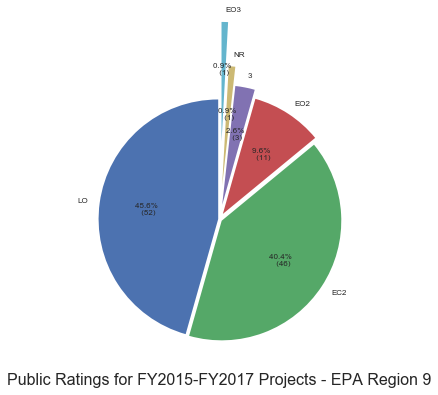

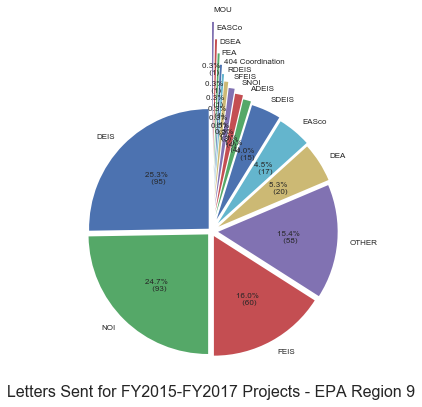

In [34]:
### Formatting Params ###
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}% \n ({v:d})'.format(p=pct,v=val)
    return my_autopct

#rat_explode = np.full((1, len(rated_rng.PUBRAT.value_counts())),.015)
rat_explode = np.geomspace(.01,.65, num=len(rated_rng['Public Rating'].value_counts()))
cat_explode = np.geomspace(.03,.75, num=len(ltr_rng['Type'].value_counts()))

### RATINGS PIE CHART - Date Range ########################################################
fig = plt.figure()
pp = PdfPages('RatingPie'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')

# plot chart
ax1 = plt.subplot(111, aspect='equal')

rated_rng['Public Rating'].value_counts().plot(
    kind='pie', 
    ax=ax1, 
    autopct=make_autopct(rated_rng['Public Rating'].value_counts()), 
    startangle=90, 
    shadow=False, 
    legend=False,
    explode = rat_explode,
    fontsize=8
)

ax1.set_ylabel('')
ax1.set_xlabel('Public Ratings for FY2015-FY2017 Projects - EPA Region 9', fontsize = 16)

## SAVE FIGURE ##
pp.savefig()
pp.close()

## SHOW PLOT INLINE ##
plt.show()
plt.clf()

plt.show()
###########################################################################################

fig = plt.figure()
pp = PdfPages('LtrPie'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')

# plot chart
ax1 = plt.subplot(111, aspect='equal')

ltr_rng['Type'].value_counts().plot(
    kind='pie', 
    ax=ax1, 
    autopct=make_autopct(ltr_rng['Type'].value_counts()), 
    startangle=90, 
    shadow=False, 
    legend=False,
    explode = cat_explode,
    fontsize=8
)

ax1.set_ylabel('')
ax1.set_xlabel('Letters Sent for FY2015-FY2017 Projects - EPA Region 9', fontsize = 16)

## SAVE FIGURE ##
pp.savefig()
pp.close()

## SHOW PLOT INLINE ##
plt.show()
plt.clf()

plt.show()


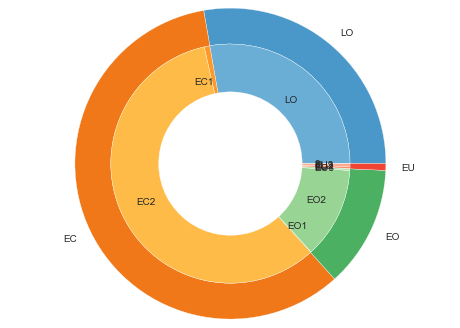

In [89]:
# Make data: I have 3 groups and 7 subgroups
group_names=['LO', 'EC', 'EO','EU']

group_size=[len(rated_all.loc[(rated_all['Env Impacts'] == 'LO')]),
            len(rated_all.loc[(rated_all['Env Impacts'] == 'EC')]),
            len(rated_all.loc[(rated_all['Env Impacts'] == 'EO')]),
            len(rated_all.loc[(rated_all['Env Impacts'] == 'EU')])] #dynamic


subgroup_names=['LO', 'EC1', 'EC2', 'EO1', 'EO2', 'EO3', 'EU1', 'EU2', 'EU3', '3']

subgroup_size=[len(rated_all.loc[(rated_all['Env Impacts'] == 'LO')]), # Deliberate outlier, exclude LO2s 
           len(rated_all.loc[(rated_all['Public Rating'] == 'EC1')]),
           len(rated_all.loc[(rated_all['Public Rating'] == 'EC2')]),
           len(rated_all.loc[(rated_all['Public Rating'] == 'EO1')]),
           len(rated_all.loc[(rated_all['Public Rating'] == 'EO2')]),
           len(rated_all.loc[(rated_all['Public Rating'] == 'EO3')]),
           len(rated_all.loc[(rated_all['Public Rating'] == 'EU1')]),
           len(rated_all.loc[(rated_all['Public Rating'] == 'EU2')]),
           len(rated_all.loc[(rated_all['Public Rating'] == 'EU3')]),
           len(rated_all.loc[(rated_all['Public Rating'] == '3')]),
          ] #dynamic
 
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.YlOrBr, plt.cm.Greens, plt.cm.Reds]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6), c(0.6), d(0.6)] )
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[
    a(0.5), 
    b(0.5), 
    b(0.4), 
    c(0.5), 
    c(0.4), 
    c(0.3), 
    d(0.5), 
    d(0.4), 
    d(0.3), 
    d(0.2)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
 
# show it
plt.show()

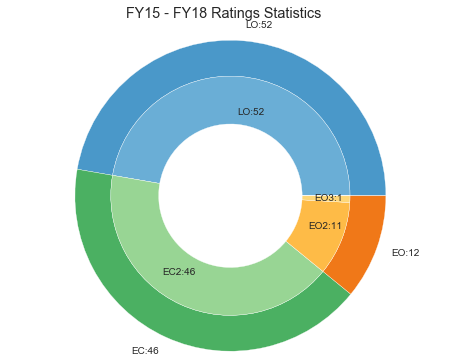

In [36]:
# Make data: I have 3 groups and 7 subgroups
fig, ax = plt.subplots()
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Greens, plt.cm.YlOrBr, plt.cm.Reds]
pp = PdfPages('RangeDblPie'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')

group_names=['LO', 'EC', 'EO','EU']

group_size=[len(rated_rng.loc[(rated_rng['Env Impacts'] == 'LO')]),
            len(rated_rng.loc[(rated_rng['Env Impacts'] == 'EC')]),
            len(rated_rng.loc[(rated_rng['Env Impacts'] == 'EO')]),
            len(rated_rng.loc[(rated_rng['Env Impacts'] == 'EU')])] #dynamic
        
group_names=['LO:'+str(group_size[0]), 
             'EC:'+str(group_size[1]), 
             'EO:'+str(group_size[2]),
             'EU:'+str(group_size[3])]
                
cmb_g = pd.DataFrame({'names': group_names,
                      'size': group_size})

cmb_g.loc[(cmb_g['size'] == 0), 'names'] = ''
        
# SUBGROUPS        
        
subgroup_size=[len(rated_rng.loc[(rated_rng['Env Impacts'] == 'LO')]), # Deliberate outlier, exclude LO2s 
               len(rated_rng.loc[(rated_rng['Public Rating'] == 'EC1')]),
               len(rated_rng.loc[(rated_rng['Public Rating'] == 'EC2')]),
               len(rated_rng.loc[(rated_rng['Public Rating'] == 'EO1')]),
               len(rated_rng.loc[(rated_rng['Public Rating'] == 'EO2')]),
               len(rated_rng.loc[(rated_rng['Public Rating'] == 'EO3')]),
               len(rated_rng.loc[(rated_rng['Public Rating'] == 'EU1')]),
               len(rated_rng.loc[(rated_rng['Public Rating'] == 'EU2')]),
               len(rated_rng.loc[(rated_rng['Public Rating'] == 'EU3')]),
               len(rated_rng.loc[(rated_rng['Public Rating'] == '3')]),
                  ] #dynamic
        
subgroup_names=['LO:'+str(subgroup_size[0]), 
                'EC1:'+str(subgroup_size[1]), 
                'EC2:'+str(subgroup_size[2]), 
                'EO1;'+str(subgroup_size[3]), 
                'EO2:'+str(subgroup_size[4]), 
                'EO3:'+str(subgroup_size[5]), 
                'EU1:'+str(subgroup_size[6]), 
                'EU2:'+str(subgroup_size[7]), 
                'EU3:'+str(subgroup_size[8]), 
                '3:'+str(subgroup_size[9])]
        
cmb_s = pd.DataFrame(
                {'names': subgroup_names,
                 'size': subgroup_size
                })

cmb_s.loc[(cmb_s['size'] == 0), 'names'] = ''
        
        
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=cmb_g['names'], colors=[a(0.6), b(0.6), c(0.6), d(0.6)] )
plt.setp( mypie, width=0.3, edgecolor='white')
    
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=cmb_s['names'], labeldistance=0.7, colors=[
                   a(0.5), 
                   b(0.5), 
                   b(0.4), 
                   c(0.5), 
                   c(0.4), 
                   c(0.3), 
                   d(0.5), 
                   d(0.4), 
                   d(0.3), 
                   d(0.2)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(1,1) 
fig.suptitle('FY15 - FY18 Ratings Statistics')

pp.savefig()
pp.close()
 
# show it
plt.show()

In [39]:
### Plot a series of pdfs that show ratings for each agency ###
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Greens, plt.cm.YlOrBr, plt.cm.Reds]
# First Ring (outside)
fig, ax = plt.subplots()
pp = PdfPages('AgencyDblPie'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')

# Get a list of the unique agencies in the dataset to loop through #
agencies = rated_rng['Lead Agencies'].drop_duplicates().dropna()
#agencies = rated_all['Lead Agencies'].drop_duplicates().dropna()

#plot_df = rated_all.groupby('Lead Agencies')
plot_df = rated_rng.groupby('Lead Agencies')

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

for agency in agencies:
    if len(plot_df.get_group(agency))>=1:
# GROUPS
        
        pltdf = plot_df.get_group(agency)
        
        group_size=[len(pltdf.loc[(pltdf['Env Impacts'] == 'LO')]),
                    len(pltdf.loc[(pltdf['Env Impacts'] == 'EC')]),
                    len(pltdf.loc[(pltdf['Env Impacts'] == 'EO')]),
                    len(pltdf.loc[(pltdf['Env Impacts'] == 'EU')])] #dynamic
        
        group_names=['LO:'+str(group_size[0]), 
                     'EC:'+str(group_size[1]), 
                     'EO:'+str(group_size[2]),
                     'EU:'+str(group_size[3])]
        
                
        cmb_g = pd.DataFrame(
                {'names': group_names,
                 'size': group_size
                })
        cmb_g.loc[(cmb_g['size'] == 0), 'names'] = ''
        
# SUBGROUPS        
        
        subgroup_size=[len(pltdf.loc[(pltdf['Env Impacts'] == 'LO')]), # Deliberate outlier, exclude LO2s 
                   len(pltdf.loc[(pltdf['Public Rating'] == 'EC1')]),
                   len(pltdf.loc[(pltdf['Public Rating'] == 'EC2')]),
                   len(pltdf.loc[(pltdf['Public Rating'] == 'EO1')]),
                   len(pltdf.loc[(pltdf['Public Rating'] == 'EO2')]),
                   len(pltdf.loc[(pltdf['Public Rating'] == 'EO3')]),
                   len(pltdf.loc[(pltdf['Public Rating'] == 'EU1')]),
                   len(pltdf.loc[(pltdf['Public Rating'] == 'EU2')]),
                   len(pltdf.loc[(pltdf['Public Rating'] == 'EU3')]),
                   len(pltdf.loc[(pltdf['Public Rating'] == '3')]),
                  ] #dynamic
        
        subgroup_names=['LO:'+str(subgroup_size[0]), 
                        'EC1:'+str(subgroup_size[1]), 
                        'EC2:'+str(subgroup_size[2]), 
                        'EO1;'+str(subgroup_size[3]), 
                        'EO2:'+str(subgroup_size[4]), 
                        'EO3:'+str(subgroup_size[5]), 
                        'EU1:'+str(subgroup_size[6]), 
                        'EU2:'+str(subgroup_size[7]), 
                        'EU3:'+str(subgroup_size[8]), 
                        '3:'+str(subgroup_size[9])]
        
        cmb_s = pd.DataFrame(
                {'names': subgroup_names,
                 'size': subgroup_size
                })
        cmb_s.loc[(cmb_s['size'] == 0), 'names'] = ''
        
        
        ax.axis('equal')
        mypie, _ = ax.pie(group_size, radius=1.3, labels=cmb_g['names'], colors=[a(0.6), b(0.6), c(0.6), d(0.6)] )
        plt.setp( mypie, width=0.3, edgecolor='white')
    
        # Second Ring (Inside)
        mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=cmb_s['names'], labeldistance=0.7, colors=[
                   a(0.5), 
                   b(0.5), 
                   b(0.4), 
                   c(0.5), 
                   c(0.4), 
                   c(0.3), 
                   d(0.5), 
                   d(0.4), 
                   d(0.3), 
                   d(0.2)])
        plt.setp( mypie2, width=0.4, edgecolor='white')
        plt.margins(1,1) 
        fig.suptitle(str(agency)+'  FY2015 - FY2017')
        
        pp.savefig()
        ax.cla()
    else:
        continue
pp.close()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


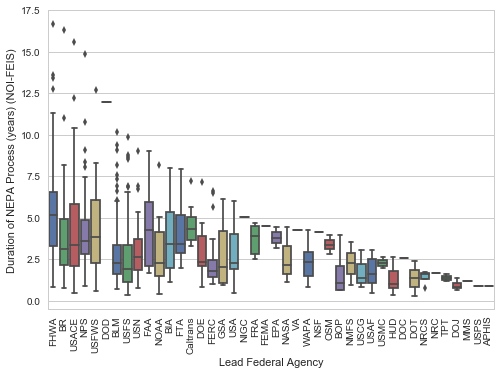

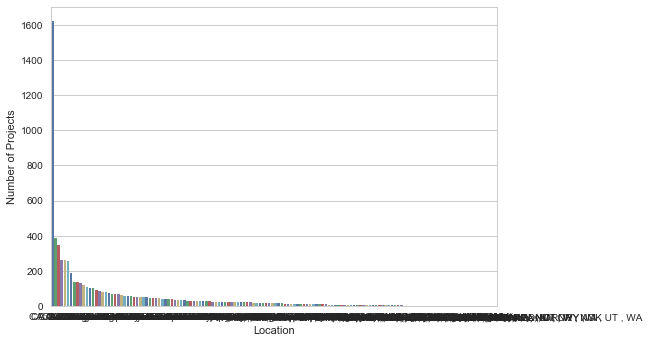

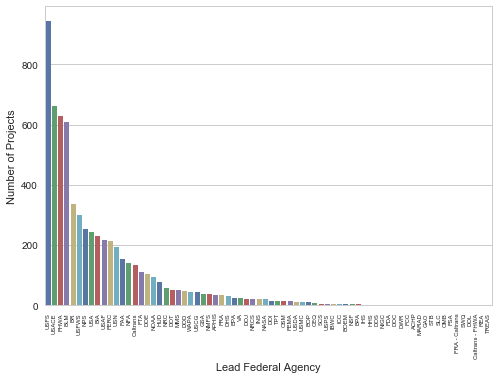

TypeError: table() takes 0 positional arguments but 2 were given

In [90]:
### Boxplots for Global Project Durations #################################################
sns.set_style("whitegrid")
fig = plt.figure()
pp = PdfPages('AgencyBox'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')

## Data Alias/Sort ##
b = join_clean
b.sort_values('duration', ascending = False, inplace = True)

## PLOTTING Call ##
ax = sns.boxplot(x='Lead Agencies',y='duration_yr',data=b, palette="deep")

## PLOT FORMATTING ##
#plt.xticks(rotation=70)
ax.set_ylabel('Duration of NEPA Process (years) (NOI-FEIS)')
ax.set_xlabel('Lead Federal Agency')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
## SAVE FIGURE ##
pp.savefig()
pp.close()

## SHOW PLOT INLINE ##
plt.show()
plt.clf()
###########################################################################################

### Barcharts for Global Project Counts - By State ########################################
sns.set_style("whitegrid")
fig = plt.figure()
pp = PdfPages('StateBar'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')
## Data Manipulation ##
s = db_parse.groupby("Locations").agg(Series.nunique)
s.reset_index(inplace = True)
s.sort_values('Main ID', ascending = False, inplace = True)

## PLOTTING Call ##
ax = sns.barplot(x='Locations',y='Main ID',data=s, palette="deep")

## PLOT FORMATTING ##
#plt.xticks(rotation=70)
ax.set_ylabel('Number of Projects')
ax.set_xlabel('Location')

## SAVE FIGURE ##
pp.savefig()
pp.close()

## SHOW PLOT INLINE ##
plt.show()
plt.clf()
###########################################################################################

### Barcharts for Global Project Counts By Agency #########################################
sns.set_style("whitegrid")
fig = plt.figure()
pp = PdfPages('AgencyBar'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')

## DATA SUBSETTING ##
a = db_parse.groupby("Lead Agencies").agg(Series.nunique)
a.reset_index(inplace = True)
a.sort_values('Main ID', ascending=False, inplace = True)

ax = sns.barplot(x='Lead Agencies',y='Main ID',data=a, palette="deep")

## PLOT FORMATTING ##
#plt.xticks(rotation=70)
ax.set_ylabel('Number of Projects')
ax.set_xlabel('Lead Federal Agency')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90, fontsize=6)
## SAVE FIGURE ##
pp.savefig()
pp.close()

## SHOW PLOT INLINE ##
plt.show()
plt.clf()
###########################################################################################

#plt.figure(figsize=(16,8))
# plot chart
ax1 = plt.subplot(121, aspect='equal')

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

explode =  np.geomspace(.01,1, num=len(rated_all['Public Rating'].value_counts()))

rated_all['Public Rating'].value_counts().plot(
    kind='pie', 
    ax=ax1, 
    autopct=make_autopct(rated_all['Public Rating'].value_counts()),
    explode = explode,
    startangle=90, 
    shadow=False, 
    legend = False, 
    fontsize=12
)

# plot table
ax2 = plt.subplot(122)
plt.axis('off')
tbl = table(ax2, 
            rated_all['Public Rating'].value_counts(), 
            loc='center',
            colWidths = [0.2],
            cellLoc='center',
            colLabels=['Rating'],
           )
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.show()

In [81]:
### Plot a series of pdfs that show project duration for each agency ###
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
fig = plt.figure()
ax1 = fig.add_subplot(111)
pp = PdfPages('AgencyTime'+date.datetime.now().strftime("%m_%d_%Y")+'.pdf')

ts_df = join_clean[['fin_yr','duration_yr','Lead Agencies']]
ts_df.sort_values('fin_yr', ascending=True, inplace = True)


# Convert it to "long-form" or "tidy" representation
df = pd.melt(ts_df, id_vars=["fin_yr","Lead Agencies"])
plot_df = df.groupby('Lead Agencies')
# Get a list of the unique agencies in the dataset to loop through #
agencies = df['Lead Agencies'].drop_duplicates()

for agency in agencies:
    if len(plot_df.get_group(agency))>2:
        
        sns.regplot(x="fin_yr", y="value", data=df.loc[(df['Lead Agencies'] == agency)], x_estimator=np.mean, ax=ax1)

        # Get a reference to the x-points corresponding to the dates and the the colors
        x = plot_df.get_group(agency).fin_yr.unique()
    
        # Calculate the 25th and 75th percentiles of the data
        # and plot a translucent band between them        
        low = plot_df.get_group(agency).groupby('fin_yr').value.apply(np.percentile, 25)
        high = plot_df.get_group(agency).groupby('fin_yr').value.apply(np.percentile, 75)
        fill_between(x, low, high, alpha=.2, color='red')
        
        ylim(0,20)       
        ax1.set_xlabel("FEIS Completion Year")
        ax1.set_ylabel("Time Between NOI and FEIS (years)")
        ax1.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x))))
        plt.title(str(agency))
        
        pp.savefig()
        ax1.cla()
    else:
        continue
pp.close()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
